## Adaptive IMLE vs Vanilla IMLE
In this notebook, we showcase a very basic implementation for [Adaptive IMLE](paper_link) and [Vanilla IMLE](https://arxiv.org/abs/1809.09087) in 2D.

While Vanilla IMLE fails to cover all data examples even in this simple situation, Adaptive IMLE covers all data examples showing superior mode-coverage. 

In [2]:
import os
import torch
import copy
import torch.nn as nn
import torch.nn.functional as F
import imageio
from tqdm import tqdm
from matplotlib import pyplot as plt
import random
import numpy as np
import seaborn as sns
import pandas as pd
from siren_pytorch import SirenNet
from prdc import compute_prdc
import random 

seed = 0
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [3]:
from scipy import interpolate

class Angle_Generator:
    def __init__(self, dim):
        self.dim = dim
        curve, inverse_cdf = self.sample(self.f)

        self.curve = curve
        self.inverse_cdf = inverse_cdf

    def f(self, x):
        # does not need to be normalized
        return np.sin(x)** (self.dim - 2)

    def sample(self, g):
        x = np.linspace(0,np.pi,10000)
        y = g(x)                        # probability density function, pdf
        cdf_y = np.cumsum(y)            # cumulative distribution function, cdf
        cdf_y = cdf_y/cdf_y.max()       # takes care of normalizing cdf to 1.0
        inverse_cdf = interpolate.interp1d(cdf_y,x) # this is a function
        curve = interpolate.interp1d(x,cdf_y) 
        self.curve = curve
        self.inverse_cdf = inverse_cdf
        return curve, inverse_cdf

    def return_samples(self, N=1000, angle_low = 0, angle_high = np.pi):
        # let's generate some samples according to the chosen pdf, f(x)
        u_low = self.curve(angle_low)
        u_high = self.curve(angle_high)
        uniform_samples = np.random.uniform(u_low, u_high,int(N))
        required_samples = self.inverse_cdf(uniform_samples)
        required_samples = required_samples.astype(np.float32)
        return required_samples

### Generator
Here we define a simple generator consisting of a few fully connected layers. We initial its weight using standard Gaussian.

In [4]:
def init_weights(m):
    def truncated_normal_init(t, mean=0.0, std=0.5):
        torch.nn.init.normal_(t, mean=mean, std=std)
        while True:
            cond = torch.logical_or(t < mean - 2 * std, t > mean + 2 * std)
            if not torch.sum(cond):
                break
            t = torch.where(cond, torch.nn.init.normal_(torch.ones(t.shape), mean=mean, std=std), t)
        return t
    

In [5]:
class Generator(nn.Module):
    def __init__(self, n_mlp=5, in_dim=32, out_dim=2, hidden_dim=128):
        super().__init__()
        assert(n_mlp >= 2)

        layers = [nn.Linear(in_dim, hidden_dim), nn.LeakyReLU(0.2)]
        for i in range(n_mlp - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Sigmoid())
        layers.append(nn.Linear(hidden_dim, out_dim))
        self.layers = nn.Sequential(*layers)
#         self.apply(init_weights)        


    def forward(self, latents):
        return self.layers(latents)

In [6]:
class Generator(nn.Module):
    def __init__(self, n_mlp=5, in_dim=32, out_dim=2, hidden_dim=128):
        super().__init__()
        assert(n_mlp >= 2)

        layers = [nn.Linear(in_dim, hidden_dim), nn.LeakyReLU(0.2)]
        for i in range(n_mlp - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Sigmoid())
        layers.append(nn.Linear(hidden_dim, out_dim))
        self.layers = nn.Sequential(*layers)
#         self.apply(init_weights)        


    def forward(self, latents):
        return self.layers(latents)

### Plotting function
We define a simple plotting function to visualize data examples and generated examples.

In [7]:
def plot_kde(generated, data_points, f_name, title):
    plt.clf()
    data = pd.DataFrame.from_dict({'x': generated[:, 0], 'y': generated[:, 1]})
    plt.figure(figsize=(8, 6))
    plt.ylim(-0.3, 0.4)
    plt.xlim(-0.35, 0.35)
    plt.title(title)
    plt.scatter(data_points[:, 0], data_points[:, 1], label="Real data points", color="blue")
    sns.kdeplot(data=data, fill=True, levels=200, alpha=0.5, palette="rocket_r") 
    plt.savefig(f_name)
    plt.close()

    

def plot_nns(g, data_points, zs, selected_z, title=None, f_name=None, arrow=False, vanilla=False):
    generated = g(zs).detach()
    if(not vanilla):
        selected = g(selected_z).detach()
    plt.figure(figsize=(8, 6))
    # plt.rcParams["figure.figsize"] = [7.50, 3.50]
    plt.scatter(data_points[:, 0], data_points[:, 1], label="Real data points", color="blue", marker="s")
    plt.scatter(generated[:, 0], generated[:, 1], label="Generated samples", color="orange", alpha=0.4, marker=".")
    if(not vanilla):
        plt.scatter(selected[:, 0], selected[:, 1], label="Nearest neighbours", color="red",marker=".")

    if arrow:
        gen_to_data_vec = data_points - generated
        # unit_vecs = gen_to_data_vec / np.linalg.norm(gen_to_data_vec, axis=1)[:, None]
        plt.quiver(generated[:, 0], generated[:, 1], 0.19*gen_to_data_vec[:, 0], 0.19*gen_to_data_vec[:, 1],
                   color="black", scale_units="xy", angles='xy', scale=0.2, width=0.0015, headwidth=10, headlength=10, label="Nearest neighbour vectors")

    plt.legend()
    plt.title(title)
    plt.ylim(-1.2, 1.2)
    plt.xlim(-1.2, 1.2)
    if f_name:
        plt.savefig(f_name)
        plt.close()
        #plot_kde(generated, data_points, f_name.replace(".png", "_kde.png"), title)
    else:
        plt.show()
        

def plot_final(g, data_points, zs, selected_z, title=None, f_name=None, arrow=False, vanilla=False):
    generated = g(zs).detach()
    if(not vanilla):
        selected = g(selected_z).detach()
    plt.figure(figsize=(8, 6))
    # plt.rcParams["figure.figsize"] = [7.50, 3.50]
    # plt.scatter(data_points[:, 0], data_points[:, 1], label="Real data points", color="blue", marker="s")
    plt.scatter(generated[:, 0], generated[:, 1], label="Generated samples", color="orange", alpha=0.1, marker=".")
    if(not vanilla):
        plt.scatter(selected[:, 0], selected[:, 1], label="Nearest neighbours", color="red",marker=".")

    if arrow:
        gen_to_data_vec = data_points - generated
        # unit_vecs = gen_to_data_vec / np.linalg.norm(gen_to_data_vec, axis=1)[:, None]
        plt.quiver(generated[:, 0], generated[:, 1], 0.19*gen_to_data_vec[:, 0], 0.19*gen_to_data_vec[:, 1],
                   color="black", scale_units="xy", angles='xy', scale=0.2, width=0.0015, headwidth=10, headlength=10, label="Nearest neighbour vectors")

    plt.legend()
    plt.title(title)
    plt.ylim(-1.2, 1.2)
    plt.xlim(-1.2, 1.2)
    if f_name:
        plt.savefig(f_name)
        plt.close()
        #plot_kde(generated, data_points, f_name.replace(".png", "_kde.png"), title)
    else:
        plt.show()

### Hyperparameters
Here we defined a few hyperparameters.

In [8]:
zdim = 64  # latent space dimension

# Dataset
Here we consider some 2D data examples defined by _data\_points_. We create a generator object and visualize some generated samples.

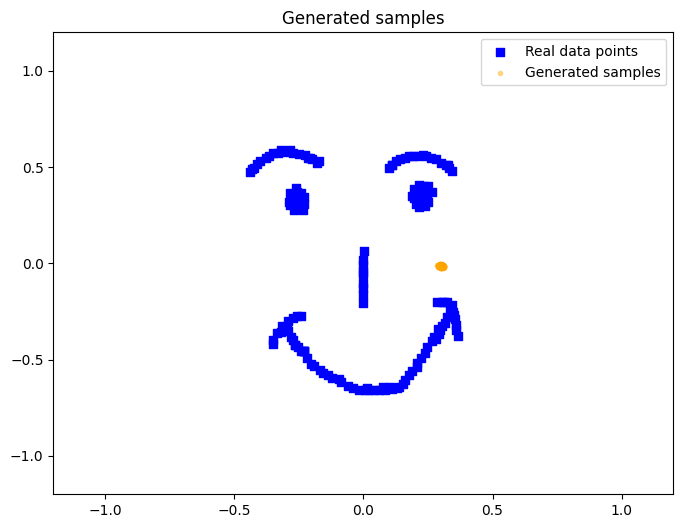

In [9]:
g = Generator(n_mlp=4, in_dim=zdim, hidden_dim=16)
# g = GeneratorLehsun(n_mlp=4, in_dim=zdim)
# data_points = torch.tensor([
#         [-0.1257,  0.3797],
#         [-0.1573,  0.1287],
#         [ 0.1076,  0.0971],
#         [ 0.1443,  0.1333],
#         [-0.1243,  0.1533],
#         [-0.0321,  0.1898],
#         [ 0.1347, -0.1573],
#         [-0.3069,  0.2949],
#         [ 0.0202,  0.1158],
#         [ 0.3023,  0.3158],
#         [ 0.2379, -0.2279],
#         [-0.2379, -0.2279],
#         [-0.0295,  0.0197],
#         [ 0.0853, -0.0708]])

data_points = torch.load("smiley.pt")

data_points -= torch.mean(data_points, 0)
data_points /= torch.tensor([20,10])

n = data_points.shape[0]
nz = data_points.shape[0]*10  # pool size
zs = torch.randn(nz, zdim)

plot_nns(g, data_points, zs, None, title="Generated samples", vanilla=True)

In [10]:
lr = 0.01  # learning rate
epochs = 10000  # number of epochs for training
tau=0.85  # tightening threshold defined in the Adaptive IMLE paper
noise_coef = 0.000001  # additive noise coeficient
staleness = 1000  # staleness for Vanilla IMLE

### Nearest Neighbours
Here we define a naive function to find nearest neighbour of each data example. This nearest neighbour part can be vastly optimized using [DCI](https://arxiv.org/abs/1703.00440).

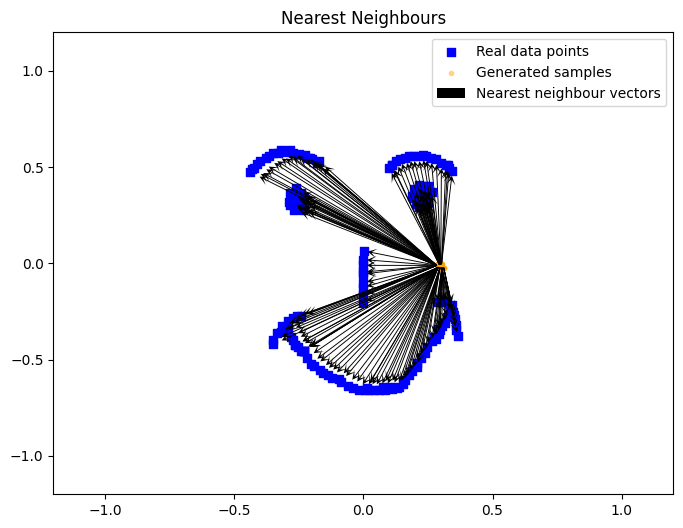

In [11]:
def find_nn(data_point, generated):
    dists = torch.sum((generated - data_point)**2, dim=1)
    dists = dists**0.5
    return torch.argmin(dists).item()

def find_nn_new(data_point, generated, limit = 1e-3):
    dists = torch.sum((generated - data_point)**2, dim=1)
    dists = dists**0.5
    to_update = dists < limit
    dists[to_update] = np.inf
    return torch.argmin(dists).item()

def find_nn_k(data_point, generated, k = 3):
    dists = torch.sum((generated - data_point)**2, dim=1)
    dists = dists**0.5
    least_k = torch.topk(dists, k, sorted=True, largest=False)
    return least_k.indices[k-1]

generated = g(zs).detach()
nns = [find_nn(data_points[i], generated) for i in range(n)]

plot_nns(g, data_points, zs[nns], None, title="Nearest Neighbours", arrow=True, vanilla=True)

In [12]:
def new_sampling_uniform(z_org,nz,angle_generator,angle_low=None,angle_high=None):
    
    if(angle_low == None):
        angle_low = torch.deg2rad(torch.tensor(10.0))
    
    if(angle_high == None):
        angle_high = torch.deg2rad(torch.tensor(30.0))
        
    repeat_z_org = z_org.repeat((nz,1))
    norm_z_org = nn.functional.normalize(repeat_z_org, dim=1, p=2)
      
    b = torch.normal(0,1,size=repeat_z_org.shape)
    norms = torch.norm(b,dim=1,p=2)
    b = nn.functional.normalize(b, dim=1)

    w = b - torch.unsqueeze(torch.einsum('ij,ij->i',b,norm_z_org),-1) * norm_z_org
    w = nn.functional.normalize(w,p=2,dim=-1)
    
    angle_sampled = torch.from_numpy(angle_generator.return_samples(norm_z_org.shape[0],angle_low = angle_low, angle_high=angle_high))
    angle_sampled = torch.unsqueeze(angle_sampled,-1)
    
    new_z = torch.cos(angle_sampled) * norm_z_org + torch.sin(angle_sampled) * w
    new_z = new_z * norms.view(-1, 1)
    return new_z
    


def new_sampling_uniform_random(z_org,nz,angle_generator,angle_low=None,angle_high=None,randomness = 0.0):
    
    if(angle_low == None):
        angle_low = torch.deg2rad(torch.tensor(10.0))
    
    if(angle_high == None):
        angle_high = torch.deg2rad(torch.tensor(30.0))

    num_of_random = int(z_org.shape[0] * randomness)
    indices = np.random.choice(z_org.shape[0], num_of_random, replace=False)

    z_org[indices] = torch.randn(num_of_random, z_org.shape[1])
        
    repeat_z_org = z_org.repeat((nz,1))
    norm_z_org = nn.functional.normalize(repeat_z_org, dim=1, p=2)
      
    b = torch.normal(0,1,size=repeat_z_org.shape)
    norms = torch.norm(b,dim=1,p=2)
    b = nn.functional.normalize(b, dim=1)

    w = b - torch.unsqueeze(torch.einsum('ij,ij->i',b,norm_z_org),-1) * norm_z_org
    w = nn.functional.normalize(w,p=2,dim=-1)
    
    angle_sampled = torch.from_numpy(angle_generator.return_samples(norm_z_org.shape[0],angle_low = angle_low, angle_high=angle_high))
    angle_sampled = torch.unsqueeze(angle_sampled,-1)
    
    new_z = torch.cos(angle_sampled) * norm_z_org + torch.sin(angle_sampled) * w
    new_z = new_z * norms.view(-1, 1)
    return new_z
    




def new_sampling(z_org,nz,angle=None):
    
    if(angle == None):
        angle = torch.deg2rad(torch.tensor(10.0))
        
    repeat_z_org = z_org.repeat((nz,1))
    norm_z_org = nn.functional.normalize(repeat_z_org, dim=1, p=2)
    b = torch.normal(0,1,size=repeat_z_org.shape)
    norms = torch.norm(b,dim=1,p=2)

    b = nn.functional.normalize(b, dim=1)
    w = b - torch.unsqueeze(torch.einsum('ij,ij->i',b,norm_z_org),-1) * norm_z_org
    w = nn.functional.normalize(w,p=2,dim=-1)
    
    new_z = torch.cos(angle) * norm_z_org + torch.sin(angle) * w
    new_z = new_z * norms.view(-1, 1)
    return new_z
    

## IMLE with splatter

In [13]:
epochs = 30000
nz = data_points.shape[0]*10
splatter_imle_g = copy.deepcopy(g)
optim = torch.optim.Adam(splatter_imle_g.parameters(), lr=lr)
staleness = 200
plot_staleness = 5000
ada_imle_nn_z = torch.randn(n, zdim)
# ada_imle_nn_z = nn.functional.normalize(ada_imle_nn_z, dim=1)

dists = torch.tensor([0.1] * n)
prev = dists[:]
angle = 3.0
angle_distort = torch.deg2rad(torch.tensor(angle))
angle_generator = Angle_Generator(zdim)
angle_high = torch.deg2rad(torch.tensor(60.0))
angle_low = torch.deg2rad(torch.tensor(40.0))

for e in tqdm(range(epochs)):
    with torch.no_grad():
        dists = torch.sum((splatter_imle_g(ada_imle_nn_z) - data_points)**2, dim=1)
        to_update = dists < prev * tau 

        zs = torch.randn(nz, zdim)
#         zs = new_sampling(ada_imle_nn_z,10,angle_sample)
#         zs = new_sampling_uniform(ada_imle_nn_z,10,angle_generator,angle_low,angle_high)


#         zs = nn.functional.normalize(zs, dim=1)

        generated = splatter_imle_g(zs).detach()
        nns = torch.tensor([find_nn(d, generated) for d in data_points[to_update]], dtype=torch.long)
        ada_imle_nn_z[to_update] = zs[nns] + torch.randn(nns.shape[0], zdim) * noise_coef

        generated = splatter_imle_g(ada_imle_nn_z)
        dists = torch.sum((generated - data_points)**2, dim=1)
        prev[to_update] = dists[to_update] * tau
        # save data as tensor
        
        if e % staleness == 0:
            nz_fake = data_points.shape[0]*10
            zs_fake = torch.randn(nz_fake, zdim)
#             zs_fake = nn.functional.normalize(zs_fake, dim=1)
        
        if e % plot_staleness == 0:
            plot_nns(splatter_imle_g, data_points, zs_fake, ada_imle_nn_z, title=f"Epoch {e}", f_name=f"plots_new_smiley/splatter-epoch-{e}-{nz}-{angle}.png", arrow=False)


    optim.zero_grad()
    
    norms = torch.norm(ada_imle_nn_z,dim=1,p=2)
    norm_ada_imle_nn_z = nn.functional.normalize(ada_imle_nn_z, dim=1, p=2)
      
    b = torch.normal(0,1,size=norm_ada_imle_nn_z.shape)
    b = nn.functional.normalize(b, dim=1)

    w = b - torch.unsqueeze(torch.einsum('ij,ij->i',b,norm_ada_imle_nn_z),-1) * norm_ada_imle_nn_z
    w = nn.functional.normalize(w,p=2,dim=-1)

    cur_batch_latents = torch.cos(angle_distort) * norm_ada_imle_nn_z + torch.sin(angle_distort) * w
    
#     print(torch.norm(cur_batch_latents,dim=1))
#     print(norms.shape)
    cur_batch_latents = cur_batch_latents * norms.view(-1, 1)
    
    outs = splatter_imle_g(cur_batch_latents)
    dists = torch.sum((outs - data_points)**2, dim=0)

    loss = dists.mean()
    loss.backward()
    optim.step()

# #Saving the training visualizations as GIF
# with imageio.get_writer(f'plots_new_smiley/splatter_imle_training-{nz}-{angle}.gif', mode='I') as writer:
#     for e in range(0,epochs,plot_staleness):
#         filename = f"plots_new_smiley/splatter-epoch-{e}-{nz}-{angle}.png"
#         image = imageio.imread(filename)
#         writer.append_data(image)
#         #os.remove(filename)

# with imageio.get_writer(f'adaptive_imle_training_kde.gif', mode='I') as writer:
#     for e in range(0,epochs,staleness):
#         filename = f"plots/ada-epoch-{e}_kde.png"
#         image = imageio.imread(filename)
#         writer.append_data(image)
#         os.remove(filename)

nz_fake = data_points.shape[0]*10
zs_fake = torch.randn(nz_fake, zdim)
# zs_fake = nn.functional.normalize(zs_fake, dim=1)
plot_final(splatter_imle_g, data_points, zs_fake, None, title="AdaIMLE", f_name=f"plots_new_smiley/splatter-final-{nz}-{angle}.png", arrow=False, vanilla=True)


  0%|          | 0/30000 [00:00<?, ?it/s]/home/cva19/anaconda3/envs/pypi/lib/python3.8/site-packages/torch/autograd/__init__.py:145: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /opt/conda/conda-bld/pytorch_1627336325426/work/c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(
 16%|█▌        | 4793/30000 [00:11<00:58, 428.91it/s]


KeyboardInterrupt: 

In [40]:
splatter_imle_g.eval()
nz_fake = data_points.shape[0]*1
zs_fake = torch.randn(nz_fake, zdim)
fake = splatter_imle_g(zs_fake).cpu().detach().numpy()
metrics = compute_prdc(real_features=data_points,
                       fake_features=fake,
                       nearest_k=3)

print(metrics)

Num real: 162 Num fake: 162
{'precision': 0.7469135802469136, 'recall': 0.9506172839506173, 'density': 0.7860082304526748, 'coverage': 0.8209876543209876}


In [17]:
zs = torch.randn(1, zdim)
angle_high = torch.deg2rad(torch.tensor(60.0))
angle_low = torch.deg2rad(torch.tensor(40.0))
angle_sample = torch.deg2rad(torch.tensor(90.0))
zs_around = new_sampling_uniform(zs,10,angle_generator,angle_low,angle_high)
zs_around2 = new_sampling(zs,20,angle_sample)
# zs_around = torch.randn(10, zdim)

generated = splatter_imle_g(zs).detach()
generated_around = splatter_imle_g(zs_around).detach()
generated_around2 = splatter_imle_g(zs_around2).detach()


plt.figure(figsize=(8, 6))
    # plt.rcParams["figure.figsize"] = [7.50, 3.50]
    # plt.scatter(data_points[:, 0], data_points[:, 1], label="Real data points", color="blue", marker="s")
plt.scatter(generated[:, 0], generated[:, 1], label="Generated samples", color="orange", alpha=0.9)
plt.scatter(generated_around[:, 0], generated_around[:, 1], label="Generated samples", color="blue", alpha=0.4, marker=".")
# plt.scatter(generated_around2[:, 0], generated_around2[:, 1], label="Generated samples", color="green", alpha=0.4, marker=".")
plt.ylim(-1.2, 1.2)
plt.xlim(-1.2, 1.2)

NameError: name 'angle_generator' is not defined

## New sampling

In [14]:
epochs = 30000
nz = data_points.shape[0]*10
new_sampling_ada_imle_g = copy.deepcopy(g)
optim = torch.optim.Adam(new_sampling_ada_imle_g.parameters(), lr=lr)
staleness = 200
plot_staleness = 5000
ada_imle_nn_z = torch.randn(n, zdim)
# ada_imle_nn_z = nn.functional.normalize(ada_imle_nn_z, dim=1)

dists = torch.tensor([0.1] * n)
prev = dists[:]
angle = 3.0
angle_distort = torch.deg2rad(torch.tensor(angle))
angle_generator = Angle_Generator(zdim)
angle_high = 60.0
angle_low = 30.0
angle_high_tensor = torch.deg2rad(torch.tensor(angle_high))
angle_low_tensor = torch.deg2rad(torch.tensor(angle_low))

for e in tqdm(range(epochs)):
    with torch.no_grad():
        dists = torch.sum((new_sampling_ada_imle_g(ada_imle_nn_z) - data_points)**2, dim=1)
        to_update = dists < prev * tau 

#         zs = torch.randn(nz, zdim)
#         zs = new_sampling(ada_imle_nn_z,10,angle_sample)
        zs = new_sampling_uniform(ada_imle_nn_z,10,angle_generator,angle_low_tensor,angle_high_tensor)


#         zs = nn.functional.normalize(zs, dim=1)

        generated = new_sampling_ada_imle_g(zs).detach()
        nns = torch.tensor([find_nn(d, generated) for d in data_points[to_update]], dtype=torch.long)
        ada_imle_nn_z[to_update] = zs[nns] + torch.randn(nns.shape[0], zdim) * noise_coef

        generated = new_sampling_ada_imle_g(ada_imle_nn_z)
        dists = torch.sum((generated - data_points)**2, dim=1)
        prev[to_update] = dists[to_update] * tau
        # save data as tensor
        
        if e % staleness == 0:
            nz_fake = data_points.shape[0]*10
            zs_fake = torch.randn(nz_fake, zdim)
#             zs_fake = nn.functional.normalize(zs_fake, dim=1)
        
        if e % plot_staleness == 0:
            plot_nns(new_sampling_ada_imle_g, data_points, zs_fake, ada_imle_nn_z, title=f"Epoch {e}", f_name=f"plots_new_smiley/ns-splatter-ada-epoch-{e}-{angle_low}-{angle_high}.png", arrow=False)


    optim.zero_grad()
    
    norms = torch.norm(ada_imle_nn_z,dim=1,p=2)
    norm_ada_imle_nn_z = nn.functional.normalize(ada_imle_nn_z, dim=1, p=2)
      
    b = torch.normal(0,1,size=norm_ada_imle_nn_z.shape)
    b = nn.functional.normalize(b, dim=1)

    w = b - torch.unsqueeze(torch.einsum('ij,ij->i',b,norm_ada_imle_nn_z),-1) * norm_ada_imle_nn_z
    w = nn.functional.normalize(w,p=2,dim=-1)

    cur_batch_latents = torch.cos(angle_distort) * norm_ada_imle_nn_z + torch.sin(angle_distort) * w
    
    cur_batch_latents = cur_batch_latents * norms.view(-1, 1)
    
    outs = new_sampling_ada_imle_g(cur_batch_latents)
    dists = torch.sum((outs - data_points)**2, dim=0)

    loss = dists.mean()
    loss.backward()
    optim.step()


nz_fake = data_points.shape[0]*10
zs_fake = torch.randn(nz_fake, zdim)
# zs_fake = nn.functional.normalize(zs_fake, dim=1)
plot_final(new_sampling_ada_imle_g, data_points, zs_fake, None, title="AdaIMLE", f_name=f"plots_new_smiley/ns-splatter-ada-final-{angle_low}-{angle_high}.png", arrow=False, vanilla=True)


  0%|          | 0/30000 [00:00<?, ?it/s]


NameError: name 'new_sampling_uniform' is not defined

## K-NN 

### Vanilla IMLE implementation
Here we implement a basic version of Vanilla IMLE.

In [41]:
imle_g = copy.deepcopy(g)
optim = torch.optim.Adam(imle_g.parameters(), lr=lr)
imle_nn_z = torch.randn(n, zdim)
epochs = 30000
staleness = 200

for e in tqdm(range(epochs)):
    with torch.no_grad():
        if e % staleness == 0:
            zs = torch.randn(nz, zdim)
            generated = imle_g(zs).detach()
            nns = torch.tensor([find_nn_new(d, generated) for d in data_points], dtype=torch.long)
            imle_nn_z = zs[nns] + torch.randn(nns.shape[0], zdim) * noise_coef
        if e % plot_staleness == 0:
            plot_nns(imle_g, data_points, zs, imle_nn_z, title=f"Epoch {e}", f_name=f"plots_new_smiley/imle-epoch-{e}.png", arrow=False)

    optim.zero_grad()
    outs = imle_g(imle_nn_z)
    dists = torch.sum((outs - data_points)**2, dim=1)
    loss = dists.mean()
    loss.backward()
    optim.step()

# Saving the training visualizations as GIF
with imageio.get_writer(f'plots_smiley/imle_training.gif', mode='I') as writer:
    for e in range(0,epochs,plot_staleness):
        filename = f"plots_smiley/epoch-{e}.png"
        image = imageio.imread(filename)
        writer.append_data(image)
        #os.remove(filename)
        

# zs = torch.randn(nz, zdim)
# plot_nns(imle_g, data_points, zs, None, title="Vanilla IMLE new distance", f_name=f"plots_new_smiley/imle-final.png", arrow=False, vanilla=True)

nz_fake = data_points.shape[0]*10
zs_fake = torch.randn(nz_fake, zdim)
# zs_fake = nn.functional.normalize(zs_fake, dim=1)
plot_final(imle_g, data_points, zs_fake, None, title="Vanilla", f_name=f"plots_new_smiley/imle-final.png", arrow=False, vanilla=True)


# with imageio.get_writer(f'imle_training_kde.gif', mode='I') as writer:
#     for e in range(0,epochs,staleness):
#         filename = f"plots/epoch-{e}_kde.png"
#         image = imageio.imread(filename)
#         writer.append_data(image)
#         os.remove(filename)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [00:15<00:00, 1923.02it/s]


## Vanilla Splatter

In [11]:
splatter_vanilla_imle_g = copy.deepcopy(g)
optim = torch.optim.Adam(splatter_vanilla_imle_g.parameters(), lr=lr)
imle_nn_z = torch.randn(n, zdim)
epochs = 30000
staleness = 100
plot_staleness = 5000

for e in tqdm(range(epochs)):
    with torch.no_grad():
        if e % staleness == 0:
            zs = torch.randn(nz, zdim)
            generated = splatter_vanilla_imle_g(zs).detach()
            nns = torch.tensor([find_nn_new(d, generated) for d in data_points], dtype=torch.long)
            imle_nn_z = zs[nns] + torch.randn(nns.shape[0], zdim) * noise_coef
        if e % plot_staleness == 0:
            plot_nns(splatter_vanilla_imle_g, data_points, zs, imle_nn_z, title=f"Epoch {e}", f_name=f"plots_new_smiley/splt-vanilla-imle-epoch-{e}.png", arrow=False)

    optim.zero_grad()
    norms = torch.norm(imle_nn_z,dim=1,p=2)
    norm_imle_nn_z = nn.functional.normalize(imle_nn_z, dim=1, p=2)
      
    b = torch.normal(0,1,size=norm_imle_nn_z.shape)
    b = nn.functional.normalize(b, dim=1)

    w = b - torch.unsqueeze(torch.einsum('ij,ij->i',b,norm_imle_nn_z),-1) * norm_imle_nn_z
    w = nn.functional.normalize(w,p=2,dim=-1)

    cur_batch_latents = torch.cos(angle_distort) * norm_imle_nn_z + torch.sin(angle_distort) * w
    
    cur_batch_latents = cur_batch_latents * norms.view(-1, 1)
    
#     outs = new_sampling_imle_g(cur_batch_latents)
    outs = splatter_vanilla_imle_g(cur_batch_latents)
    dists = torch.sum((outs - data_points)**2, dim=1)
    loss = dists.mean()
    loss.backward()
    optim.step()

        
nz_fake = data_points.shape[0]*10
zs_fake = torch.randn(nz_fake, zdim)
# zs_fake = nn.functional.normalize(zs_fake, dim=1)
plot_final(splatter_vanilla_imle_g, data_points, zs_fake, None, title="Vanilla", f_name=f"plots_new_smiley/splt-vanilla-imle-final.png", arrow=False, vanilla=True)


  0%|          | 0/30000 [00:00<?, ?it/s]


NameError: name 'angle_distort' is not defined

## Vanilla Splatter with new sampling

In [18]:
ns_splatter_vanilla_imle_g = copy.deepcopy(g)
optim = torch.optim.Adam(ns_splatter_vanilla_imle_g.parameters(), lr=lr)
imle_nn_z = torch.randn(n, zdim)
epochs = 30000
staleness = 25
plot_staleness = 5000
angle_generator = Angle_Generator(zdim)
angle = 0.0
angle_distort = torch.deg2rad(torch.tensor(angle))
angle_high = 90.0
angle_low = 0.0
angle_high_tensor = torch.deg2rad(torch.tensor(angle_high))
angle_low_tensor = torch.deg2rad(torch.tensor(angle_low))
sample_factor = 5
nz = data_points.shape[0]*sample_factor
randomness = 0.0
randomness_staleness = 1000
vanilla = True

if(vanilla):
    angle_high = 180.0
    angle_low = 0.0
    angle_high_tensor = torch.deg2rad(torch.tensor(angle_high))
    angle_low_tensor = torch.deg2rad(torch.tensor(angle_low))


for e in tqdm(range(epochs)):
    with torch.no_grad():
        if e % staleness == 0:
            
            # if(random.random() < 0.1):
            if(vanilla):
                zs = torch.randn(nz, zdim)
            else:
                zs = new_sampling_uniform_random(imle_nn_z,sample_factor,angle_generator,angle_low_tensor,angle_high_tensor,randomness=randomness)

            # else:
            # zs = new_sampling_uniform(imle_nn_z,sample_factor,angle_generator,angle_low_tensor,angle_high_tensor)
            # zs = torch.randn(nz, zdim)

            # zs = new_sampling_uniform_random(imle_nn_z,sample_factor,angle_generator,angle_low_tensor,angle_high_tensor,randomness=randomness)
            
            # if(e % randomness_staleness == 0):
            #     randomness = randomness * 0.8
                
            if(e % 1000 == 0):
                angle_high = max(angle_high - 2.0, 70.0)
                angle_high_tensor = torch.deg2rad(torch.tensor(angle_high))

            generated = ns_splatter_vanilla_imle_g(zs).detach()

            if(vanilla):
                nns = torch.tensor([find_nn(d, generated) for d in data_points], dtype=torch.long)
            else:
                nns = torch.tensor([find_nn_new(d, generated, limit=1e-2) for d in data_points], dtype=torch.long)
                # nns = torch.tensor([find_nn_new(d, generated, limit = 1e-2) for d in data_points], dtype=torch.long)

            imle_nn_z = zs[nns] + torch.randn(nns.shape[0], zdim) * noise_coef
        # if e % plot_staleness == 0:
        #     plot_nns(ns_splatter_vanilla_imle_g, data_points, zs, imle_nn_z, title=f"Epoch {e}", f_name=f"plt_smiley_5/ns-splt-vanilla-imle-epoch-{e}.png", arrow=False)

    optim.zero_grad()
    norms = torch.norm(imle_nn_z,dim=1,p=2)
    # norm_imle_nn_z = nn.functional.normalize(imle_nn_z, dim=1, p=2)
      
    # b = torch.normal(0,1,size=norm_imle_nn_z.shape)
    # b = nn.functional.normalize(b, dim=1)

    # w = b - torch.unsqueeze(torch.einsum('ij,ij->i',b,norm_imle_nn_z),-1) * norm_imle_nn_z
    # w = nn.functional.normalize(w,p=2,dim=-1)

    # cur_batch_latents = torch.cos(angle_distort) * norm_imle_nn_z + torch.sin(angle_distort) * w
    
    # cur_batch_latents = cur_batch_latents * norms.view(-1, 1)
    cur_batch_latents = imle_nn_z
    
#     outs = new_sampling_imle_g(cur_batch_latents)
    outs = ns_splatter_vanilla_imle_g(cur_batch_latents)
    dists = torch.sum((outs - data_points)**2, dim=1)
    loss = dists.mean()
    loss.backward()
    optim.step()

        
nz_fake = data_points.shape[0]*10
zs_fake = torch.randn(nz_fake, zdim)
# zs_fake = nn.functional.normalize(zs_fake, dim=1)
plot_final(ns_splatter_vanilla_imle_g, data_points, zs_fake, None, title="Vanilla", f_name=f"plt_smiley_3/ns-splt-vanilla-imle-final-{sample_factor}-{angle_low}-{angle_high}-{staleness}-{randomness}.png", arrow=False, vanilla=True)


100%|██████████| 30000/30000 [00:23<00:00, 1272.28it/s]


In [66]:
import os
import shutil

def shift_files(source_folder, destination_folder):
    # Create destination folder if it doesn't exist
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Iterate through files in the source folder
    for filename in os.listdir(source_folder):
        source_path = os.path.join(source_folder, filename)

        # Check if the file contains the word "epoch"
        if "epoch" not in filename.lower():
            # Move the file to the destination folder
            destination_path = os.path.join(destination_folder, filename)
            shutil.copy(source_path, destination_path)
            print(f"Moved {filename} to {destination_folder}")

# Specify your source and destination folders
source_folder_path = "./plots_new_smiley/"
destination_folder_path = "./final_plots_new_smiley/"

# Call the function to shift files
shift_files(source_folder_path, destination_folder_path)


Moved ns-splt-vanilla-imle-final-20.0-50.0.png to ./final_plots_new_smiley/
Moved ns-splatter-ada-final-30.0-70.0.png to ./final_plots_new_smiley/
Moved ns-splatter-ada-final-30.0-60.0.png to ./final_plots_new_smiley/
Moved ns-splt-vanilla-imle-final-10.0-80.0.png to ./final_plots_new_smiley/
Moved ns-splt-vanilla-imle-final-30.0-70.0.png to ./final_plots_new_smiley/
Moved ns-splt-vanilla-imle-final-0.0-180.0.png to ./final_plots_new_smiley/
Moved ns-splt-vanilla-imle-final-40.0-70.0.png to ./final_plots_new_smiley/
Moved ns-splt-vanilla-imle-final-20.0-70.0.png to ./final_plots_new_smiley/
